# Basic analysis of input data

In [4]:
import numpy as np
import scipy.stats as sps
from scipy.ndimage import gaussian_filter
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import sys
from netCDF4 import Dataset

# sys.path.append(r'C:\Users\chral\Nextcloud\code\HIDA2020\Climate_Model_Data')
# os.chdir(r'C:\Users\chral\Dropbox\ipp\HIDA2020')
from common import *


First we load the time-series data of the forcing data to see how they look like.

Text(0.5, 1.0, 'Solar forcing')

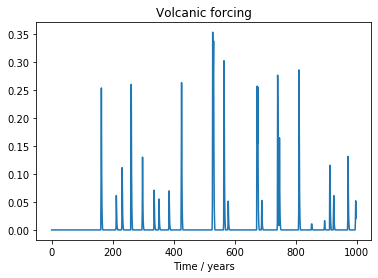

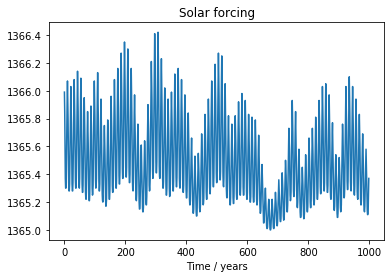

In [5]:
_, AOD = get_volcanic_data()
_, TSI = get_solar_data()

t = np.arange(len(AOD))

plt.figure()
plt.plot(t, AOD)
plt.xlabel('Time / years')
plt.title('Volcanic forcing')
plt.figure()
plt.plot(t, TSI)
plt.xlabel('Time / years')
plt.title('Solar forcing')

We notice a very different kind of time-series. While the volcanic forcing is mostly zero with distinct peaks, the solar data is strongly periodic on top of a slow trend. Let's have a look at the frequecy domain:

Text(0.5, 1.0, 'Solar forcing in frequency space')

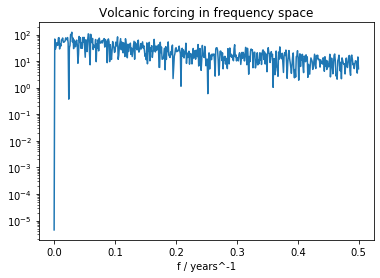

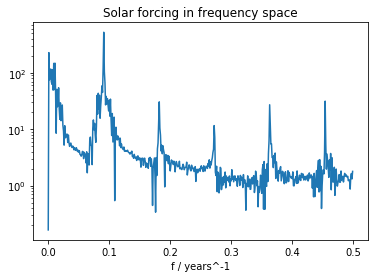

In [6]:
AOD_f = np.fft.rfft(normalize(AOD))
TSI_f = np.fft.rfft(normalize(TSI))
f = np.fft.fftfreq(len(TSI))[0:len(TSI_f)]

plt.figure()
plt.semilogy(f, np.abs(AOD_f))
plt.xlabel('f / years^-1')
plt.title('Volcanic forcing in frequency space')

plt.figure()
plt.semilogy(f, np.abs(TSI_f))
plt.xlabel('f / years^-1')
plt.title('Solar forcing in frequency space')

The mean over time differs by less than 0.05% locally, so it's a good idea to look at difference data from the mean over time

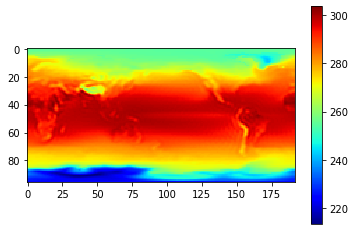

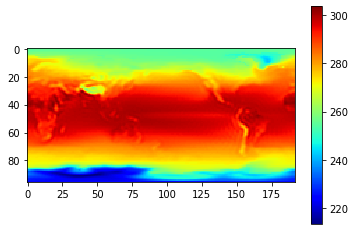

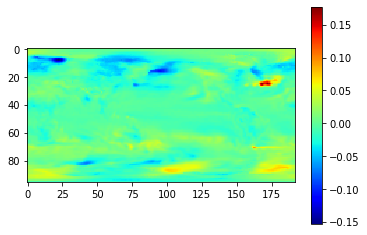

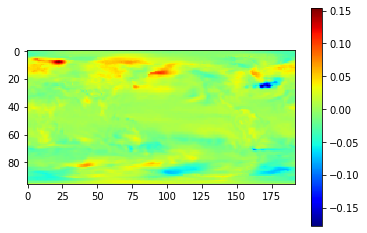

In [7]:
_, lon, lat, T1 = get_geodata(1)
_, _, _, T2 = get_geodata(2)
T1_mean = np.mean(T1, 0)
T2_mean = np.mean(T2, 0)
T_mean = (T1_mean + T2_mean)/2.0

dT1 = T1-T1_mean
dT2 = T2-T2_mean

plt.figure()
plt.imshow(T1_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T2_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T1_mean-T_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T2_mean-T_mean, cmap='jet')
plt.colorbar()

Here we compute empirical mean and std. deviation from the 2 time-series we have for temperatures to get an idea on uncertainties. Let's also check how the system reacts to volcanic forcing

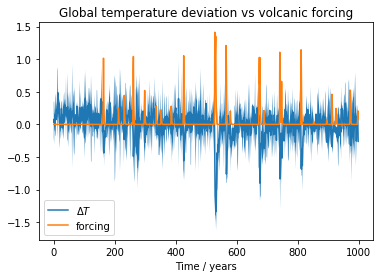

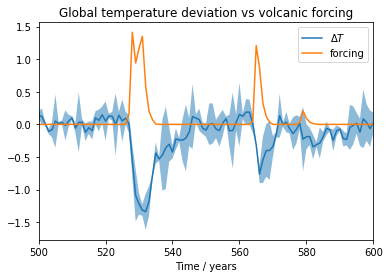

In [8]:
dT1glob = np.mean(np.mean(dT1, 2), 1)
dT2glob = np.mean(np.mean(dT2, 2), 1)
dTglob = (dT1glob + dT2glob)/2.0
var_dTglob = (dT1glob - dTglob)**2 + (dT2glob - dTglob)**2  # sample variance with n-1 = 1
err_dTglob = 1.96*np.sqrt(var_dTglob)

plt.figure()
plt.plot(t, dTglob)
plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob)
plt.plot(t, 4*AOD)
plt.xlabel('Time / years')
plt.title('Global temperature deviation vs volcanic forcing')
plt.legend([r'$\Delta T$', 'forcing'])

plt.figure()
plt.plot(t, dTglob)
plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob, alpha=0.5)
plt.plot(t, 4*AOD)
plt.xlim([500, 600])
plt.xlabel('Time / years')
plt.title('Global temperature deviation vs volcanic forcing')
plt.legend([r'$\Delta T$', 'forcing'])

To check in detail how fast the system reacts and if there is any relation, plot lagged data by X years. 

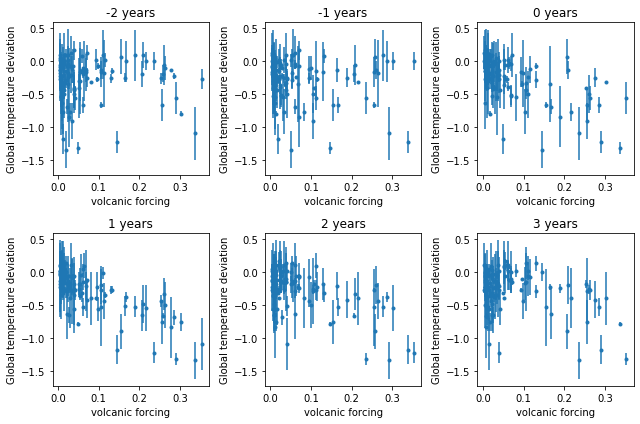

In [14]:
AODmin = 1e-2*np.max(AOD)

con = filter_ts(AODmin)
x = AOD[con]

plt.figure(figsize=(9, 6))
for lag in range(-2, 4):
    y = np.roll(dTglob[con], -lag)
    err_y = np.roll(err_dTglob[con], -lag)
    plt.subplot(2, 3, lag+3)
    plt.errorbar(x, y, yerr=err_y, fmt='.')
    plt.ylabel('Global temperature deviation')
    plt.xlabel('volcanic forcing')
    plt.title('{} years'.format(lag))
plt.tight_layout()

For volcanic forcing there is thus hope. For solar forcing, finding any dependency in the data looks difficult, at least for global mean temperature, and even for smoothed data, as seen below.

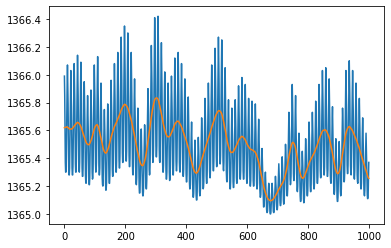

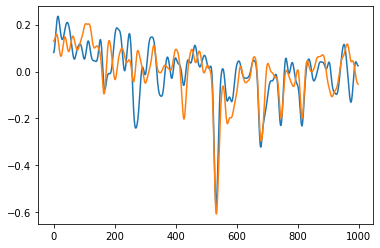

In [12]:
TSI_sm = gaussian_filter(TSI, 6)
dT1glob_sm = gaussian_filter(dT1glob, 6)
dT2glob_sm = gaussian_filter(dT2glob, 6)

plt.figure()
plt.plot(TSI)
plt.plot(TSI_sm)

plt.figure()
plt.plot(dT1glob_sm)
plt.plot(dT2glob_sm)

Text(0, 0.5, 'Solar forcing')

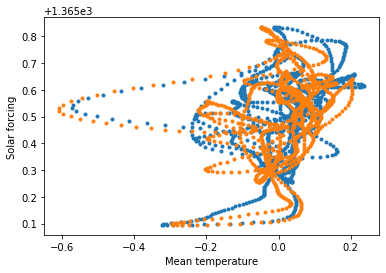

In [13]:
y = TSI_sm
xA = dT1glob_sm
xB = dT2glob_sm

plt.figure()
plt.plot(xA, y, '.')
plt.plot(xB, y, '.')
plt.xlabel('Mean temperature')
plt.ylabel('Solar forcing')

It looks a bit like the big dip in temperature due to volcanic activity is an outlier even in smoothed data.